# Introduction

This notebook is intended to familiarize users of the `sprcom` package with building, fitting and interpreting a spatial community regression model. This is a Bayesian model is designed to conduct regression of high-dimensional binary or count vectors by grouping these responses into communities or clusters, incorporating spatially-smoothed residuals at the community-level to facilitate the identification of missing covariates that should be included in the model. We will first walk through the types of data used in this modeling workflow. Next, we will build a model using this data and run Markov chain Monte Carlo to estimate its parameters. Finally, we will show how to interpret these parameter estimates. 

## Data

The source of the data for this tutorial is the [Florabank1 dataset](https://phytokeys.pensoft.net/article/1417/) which comprises observations of several thousand plant species over large portions of Belgium. The original dataset covers 12,000 sampling locations but we have taken a smaller subset of this data corresponding to the northwest corner of the country. We also obtained 8 abiotic covariates to use as predictors. Our predictors are contained in a Pandas `Dataframe` which has 1944 rows.

In [1]:
import pandas as pd

X = pd.read_pickle('../data/florabank_covariates.pkl')
print(X.shape)
X.head()

(1944, 8)


,Precipitation,Temperature,Elevation,Slope,Settlements,Low wetness,Medium wetness,High wetness
"(3.10718, 51.03749000000001)",-0.043366,0.082136,1.000202,-0.045248,0.132081,-0.827046,-0.517439,-0.157401
"(3.35949, 51.23768)",0.584122,-0.554550,-0.857831,-0.466116,-0.733225,-0.369406,-0.337895,-0.157401
"(3.0641700000000003, 51.04601)",-0.241865,-0.545519,0.371767,-0.206317,-0.733225,-0.426788,-0.517439,-0.157401
"(3.30429, 51.14731)",0.669633,-0.608735,-0.182724,-0.603109,-0.733225,-0.638932,-0.260451,-0.157401
"(3.34933, 51.04882)",0.820353,-0.741491,1.246871,-0.571693,-0.733225,-0.650461,-0.517439,-0.157401


The row index for this dataframe indicates the longitude and latitude of the sampling site, respectively. We can see the spatial distribution of these sites as well as their relative elevation with the following. Note that the covariates have already been standardized so the elevation has zero mean and unit variance.

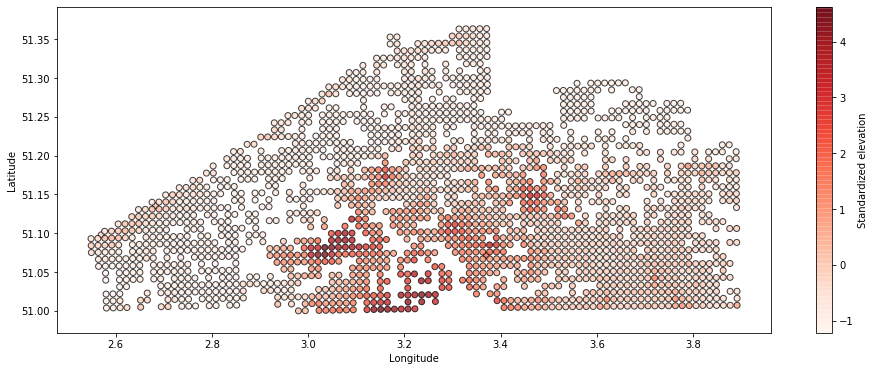

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,6))
plt.scatter(*zip(*X.index.values),c=X['Elevation'],marker='o',facecolor='None',alpha=0.75,cmap='Reds',edgecolor='k') 
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.colorbar(label='Standardized elevation');

Note that all the sampling sites shown above have at least one neighbor and most have two or more. Every site needs to have at least one adjacent neighbor and we recommend dropping any locations that do not have one. If this isn't done, numerical issues will appear with the MCMC algorithm we use later in this notebook.

Next, we load the species presence/absence data. There are 858 unique species represented in this dataset.

In [3]:
Y = pd.read_pickle('../data/florabank_response.pkl')
print(Y.shape)
Y.head()
                   

(1944, 858)


scientificname,Origanum vulgare L.,Primula veris L.,Cichorium intybus L.,Melilotus officinalis Lam.,Rubus caesius L.,Fallopia japonica (Houtt.) Ronse Decraene,Calamagrostis epigejos (L.) Roth,Hypericum dubium Leers,Achillea millefolium L.,Euonymus europaeus L.,...,Pyrus communis L.,Festuca juncifolia St.-Amans,Vicia lathyroides L.,Amaranthus albus L.,Bromus thominei Hardouin,Centaurea nigra L.,Salsola kali L.,Crataegus media Bechst.,Holosteum umbellatum L.,Serratula tinctoria L.
"(3.10718, 51.03749000000001)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.35949, 51.23768)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.0641700000000003, 51.04601)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.30429, 51.14731)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.34933, 51.04882)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can use this to make a plot of species richness, too.

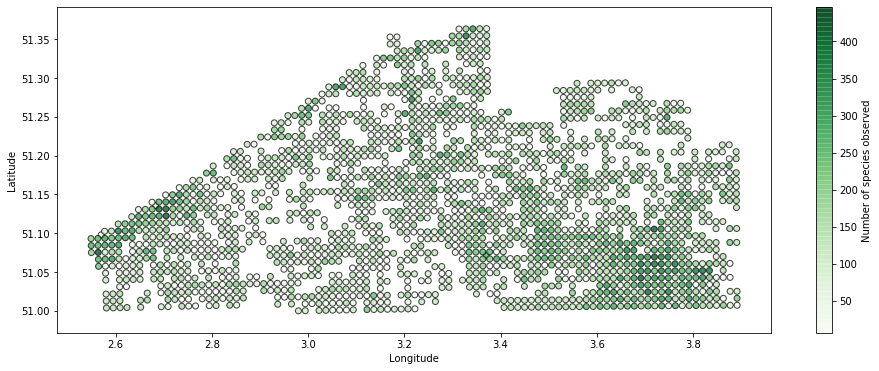

In [4]:
plt.figure(figsize=(16,6))
plt.scatter(*zip(*X.index.values),c=Y.sum(axis=1),marker='o',facecolor='None',alpha=0.75,cmap='Greens',edgecolor='k') 
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.colorbar(label='Number of species observed');

In our spatial statistical model, we assume that locations which are adjacent to each other will have similar communities. To model this behavior, we need an adjacency matrix which indicates which cells are neighbors.

In [5]:
W = pd.read_pickle('../data/florabank_adjacency.pkl')
print(W.shape)

(1944, 1944)


## Modeling

Now that we have the data, we can construct and fit our model. Before we begin, we have to choose the number of communities to be used to fit the model. This is something we need to specify a priori, though we can choose it based on cross-validation or assessment on held-out data. For this tutorial, we'll set `C` to be equal to 6.

In [6]:
C = 6

Creating the PyMC3 model object is simple - we just pass in our data as Numpy arrays to the `spatial_community_regression` function and a PyMC3 Model will be created. Before we import the `SpRCom` package, we need to configure PyMC3 and its underlying computational engine, Theano. We want to specify that a GPU should be used with the flag `device=cuda`. We can also speed up computations by using a 32 bit floating point representation of a number, so we'll also use the flag `floatX=float32`. You can remove these flags if your computer does not use a GPU.

In [7]:
import os
os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32'

from sprcom.model import spatial_community_regression
model = spatial_community_regression(X.values,Y.values,C,W.values)

Using cuDNN version 6021 on context None
Mapped name None to device cuda: TITAN Xp (0000:01:00.0)
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


We can use this model to run MCMC. Our implementation works especially well on a GPU; if you are using one as well, you need to set `cores` to 1 so that PyMC3 knows to only try one chain at a time. Alternately, you can use more than one core if you are using a CPU for calculations.

In [ ]:
import pymc3 as pm
with model:
    trace = pm.sample(cores=1,chains=2,tune=2000,draws=4000,init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 3.5531e+05: 100%|██████████| 200000/200000 [09:24<00:00, 354.14it/s]
Finished [100%]: Average Loss = 3.5531e+05
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/ckra

The samples were succesfully drawn using NUTS in PyMC3 but we need to check to see if there are any red flags. First, let's check for divergences. These occur when the sampling algorithm reaches parts of the parameter space with sharp curvature and it cannot continue on as usual.

In [ ]:
trace.get_sampler_stats('diverging').sum()

There aren't any divergences which is a good sign. Let's also check the potential scale reduction factor $\hat{R}$, also known as the Gelman-Rubin statistic. The `summary` function will automatically calculate this and other sampler statistics from `trace`. Since most of these are very close to 1, it appears that the posterior samples can reliably be used for interpretation.

In [ ]:
summary = pm.summary(trace)
summary['Rhat'].hist(); plt.xlabel('Potential scale reduction factor'); plt.ylabel('Number of parameters');

We can also look at the number of effective samples for each parameter. The code cell below sorts them in order from lowest number to highest. It appears that the conditional autoregression residual terms have the lowest number of effective samples.

In [ ]:
summary['n_eff'].sort_values().head()

## Interpretation

In [ ]:
from sprcom.utils import coefficient_plot
coefficient_plot(trace['beta'],X.columns,figsize = (5,3))

In [ ]:
fig,axes = plt.subplots(3,2,figsize=(18,10),sharex=True,sharey=True)
axes = axes.ravel()
for c in range(C):
    effect = trace['car_{0}'.format(c)].mean(axis=0)
    plt.sca(axes[c])
    plt.scatter(*zip(*X.index.values),c=effect,marker='o',s=10,
                facecolor='None',alpha=0.75,cmap='RdBu') 
    plt.colorbar(label='Residuals for community {0}'.format(c))
    plt.axis('off')
    plt.title('Community {0}'.format(c))
    
    

In [ ]:
from sprcom.utils import print_species
print_species(trace['phi'].mean(axis=0),pd.DataFrame(data = Y.columns),num_to_show=6)

In [ ]:
pm.plot_posterior(trace,varnames=['rho']);